Note that this notebook requires the [DataSets](https://github.com/rsokl/DataSets) package and utilizes [liveplot](https://github.com/rsokl/liveplot), but can be refactored not to use liveplot. You should install these dependencies before proceeding.

This notebook will walk through creating a simple 5-layer convolutional neural network and use it to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/)

First up, let's take care of our imports

In [1]:
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mynn.activations.relu import relu
from mynn.losses.cross_entropy import cross_entropy
from mynn.initializers.glorot_uniform import glorot_uniform
from mynn.optimizers.sgd import SGD

import numpy as np
from mygrad.nnet.layers.pooling import max_pool

from datasets import load_mnist
from liveplot import create_plot
%matplotlib notebook

Load the dataset!

In [2]:
train_data, train_labels, val_data, val_labels = load_mnist()

train_data = train_data / 255 # [0, 255] -> [0, 1]
val_data = val_data / 255

#train_data -= train_data.mean()
#val_data -= train_data.mean()

train_labels = train_labels.argmax(axis=1) # one-hot to index
val_labels = val_labels.argmax(axis=1)

mnist loaded


Now we'll define our model. It's a simple 5-layer CNN

In [3]:
class Model:
    ''' A simple 5-layer CNN for MNIST. '''
    def __init__(self):
        init = glorot_uniform
        args = {'gain': np.sqrt(2)}
        self.conv1 = conv(1, 16, 3, 3, padding=1, weight_initializer=init, weight_kwargs=args)
        self.conv2 = conv(16, 16, 3, 3, padding=1, weight_initializer=init, weight_kwargs=args)
        self.conv3 = conv(16, 32, 3, 3, padding=1, weight_initializer=init, weight_kwargs=args)
        self.conv4 = conv(32, 32, 3, 3, padding=1, weight_initializer=init, weight_kwargs=args)
        self.dense = dense(32*8*8, 10)
        
    def __call__(self, x):
        ''' Perform a forward pass of the model.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor]
            The data to send through the model.
            
        Returns
        -------
        mygrad.Tensor
            The output of the model (predictions).
        '''
        x = relu(self.conv2(relu(self.conv1(x))))
        x = max_pool(x, (2, 2), 2)
        x = relu(self.conv4(relu(self.conv3(x))))
        x = max_pool(x, (2, 2), 2)
        return self.dense(x.reshape(-1, 32*8*8))
    
    @property
    def parameters(self):
        ''' Access the parameters of the model.
        
        Returns
        -------
        Tuple[mygrad.Tensor, ...]
            The parameters of the model.
        '''
        params = []
        for layer in (self.conv1, self.conv2, self.conv3, self.conv4, self.dense):
            params += list(layer.parameters)
        return params

In [4]:
m = Model()

This defines the optimizer we're going to use: stochastic gradient descent. The optimizer needs the model parameters so that it can update the weights, so we'll pass those in using our attribute defined above.

In [5]:
optim = SGD(m.parameters, learning_rate=0.001, momentum=0.99)

We'll want to keep track of our loss and accuracy curves to see how training is going!


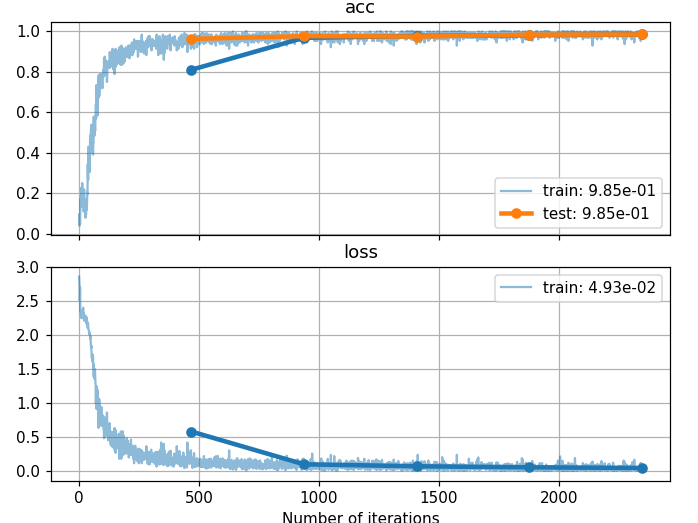

In [6]:
plotter, fig, ax = create_plot({'loss', 'acc'}, 0.1)

In [7]:
def train_epoch(batch_size=128):
    ''' Train the model for one epoch. '''
    idxs = np.arange(len(train_data)) # shuffle our data
    np.random.shuffle(idxs)
    
    for batch in range(0, len(idxs), batch_size):
        data = train_data[idxs[batch:batch+batch_size]]
        targets = train_labels[idxs[batch:batch+batch_size]]
        
        outs = m(data)                      # get the model output
        loss = cross_entropy(outs, targets) # compute the loss
        loss.backward()                     # backpropagate the loss
        optim.step()                        # train the model
        loss.null_gradients()               # clear the gradients

        # plot our training statistics
        correct = (outs.data.argmax(axis=1) == targets).sum()
        plotter.set_train_batch({'loss': loss.data, 'acc': correct / len(outs)}, len(outs))
    plotter.plot_train_epoch()

In [8]:
def evaluate_model(batch_size=256):
    for batch in range(0, len(val_data), batch_size):
        data_batch = val_data[batch:batch + batch_size]
        target_batch = val_labels[batch:batch+batch_size]
        
        outs = m(data_batch)  # get output
        outs.null_gradients() # clear the graph
        
        correct = (outs.data.argmax(axis=1) == target_batch).sum()
        plotter.set_test_batch({'acc': correct / len(outs)}, len(outs))
    plotter.plot_test_epoch()

In [9]:
for epoch in range(5):
    train_epoch()
    evaluate_model()